<a href="https://colab.research.google.com/github/Sourabh17042/House-Price-Prediction/blob/main/COVID_19_Chest_x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Chest x-ray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### The COVID-19 pandemic has been gripping much of the world recently. Although there have been much efforts gone into developing affordable testing for the masses, it has been shown that the established and widely available chest x-rays (CXR) may be used as a screening criteria. Thanks to the dedicated work by various individuals and organizations, publicly available chest x-rays of COVID-19 subjects are available for analytic usage.

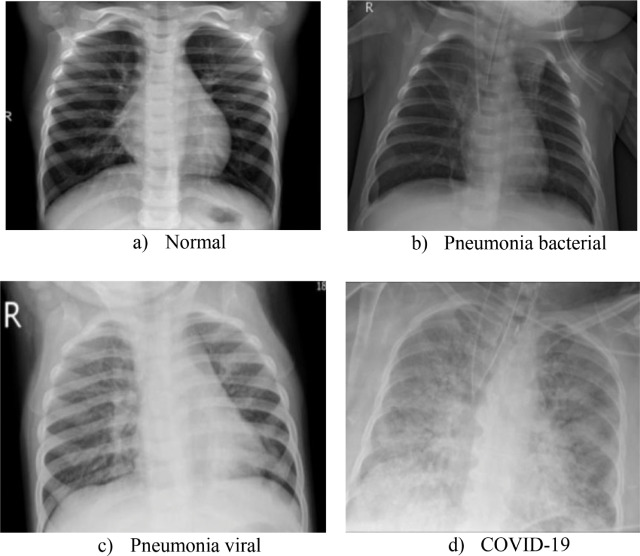

---



---



In [ ]:
import numpy as np #numerical operation
import matplotlib.pyplot as plt #visluzation

import torch
import torch.nn as nn #neural network
import torch.optim as optim # optimizer
from torch.utils.data import DataLoader
from torch.utils.data import random_split #random spliting

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [ ]:
data_path_train = "/content/drive/MyDrive/Covid19-dataset/train"
data_path_test = "/content/drive/MyDrive/Covid19-dataset/test"

In [ ]:
img_size = 120

img_transform = transforms.Compose([
                                    transforms.Resize((img_size,img_size)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485,0.456,0.475],
                                                         std = [0.229,0.224,0.225])
                                    # x - mean/std
])

In [ ]:
train_data = ImageFolder(root = data_path_train , transform=img_transform)
test_data = ImageFolder(root= data_path_test , transform=img_transform)

In [ ]:
len(train_data) , len(test_data)

(251, 66)

In [ ]:
train_data.class_to_idx

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [ ]:
test_data

Dataset ImageFolder
    Number of datapoints: 66
    Root location: /content/drive/MyDrive/Covid19-dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(120, 120), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.475], std=[0.229, 0.224, 0.225])
           )

In [ ]:
val_data , test_data = random_split(test_data , [50,16])

In [ ]:
len(val_data) , len(test_data)

(50, 16)

In [ ]:
test_data.dataset

Dataset ImageFolder
    Number of datapoints: 66
    Root location: /content/drive/MyDrive/Covid19-dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(120, 120), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.475], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_loader = DataLoader(train_data , batch_size=16 , shuffle=True)
val_loader = DataLoader(val_data,batch_size=16,shuffle = True)

In [ ]:
for img,label in train_loader:  # [N , C , H , W]
  print(img.shape)
  break

torch.Size([16, 3, 120, 120])


In [ ]:
def show_img(data):
  for img,label in data:
    plt.figure(figsize=(12,6))
    plt.imshow(make_grid(img,n_rows=5).permute(1,2,0))
    plt.show()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


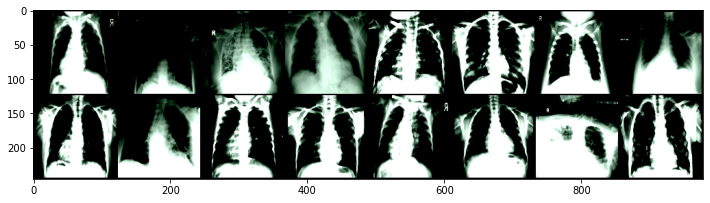

In [ ]:
show_img(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


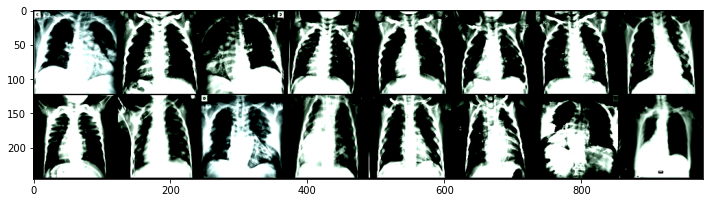

In [ ]:
show_img(val_loader)

In [ ]:
class ANN(nn.Module):
  def __init__(self,hidden_layer = 64):
    super(ANN,self).__init__()

    self.fc1 = nn.Linear(120*120*3 , hidden_layer)
    self.fc2 = nn.Linear(hidden_layer , 3)

    self.relu = nn.ReLU()


  def forward(self,img):
    # [N C W H]
    out = img.view(-1,120*120*3)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)

    return out

In [ ]:
model =ANN()
print(model.parameters)

<bound method Module.parameters of ANN(
  (fc1): Linear(in_features=43200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
)>


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr =0.001)

In [ ]:
def train(model,loss_fn,optimizer):

  epochs = 15

  training_loss = []
  training_acc = []
  validation_loss = []
  validation_acc = []

  for epoch in range(epochs):

    train_loss = 0.0
    train_acc = 0.0

    model.train()

    for images,labels in train_loader:

      optimizer.zero_grad() # resent the gradeint

      output = model(images)
      loss = loss_fn(output,labels)



      loss.backward() # calculate the gradient
      optimizer.step() # Wn = Wo - lr * grad


      predictions = torch.argmax(output,1)

      train_acc += (predictions==labels).sum().item()

      train_loss += loss.item()

    training_acc.append(train_acc/len(train_data))
    training_loss.append(train_loss/len(train_loader))

    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
      for images, labels in val_loader:

        output = model(images)
        loss = loss_fn(output,labels)

        predictions = torch.argmax(output ,1)

        val_acc += (predictions == labels).sum().item()
        val_loss += loss.item()

    validation_loss.append(val_loss/len(val_loader))
    validation_acc.append(val_acc/len(val_data))


    print("Epochs {} , Training Acc {:.2f} , Training Loss {:.2f} , Validation Acc {:.2f}, Validation Loss {:.2f}".format(
        epoch+1 , train_acc/len(train_data) , train_loss/len(train_loader) , val_acc/len(val_data) , val_loss/len(val_loader)
    ))


  plt.title("Accuracy vs Epoch")
  plt.plot(range(epochs),training_acc,label = "training Accuracy")
  plt.plot(range(epochs),validation_acc , label = "validation Accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Training/Validation Accuracy")
  plt.show()

  plt.title("Loss vs Epoch")
  plt.plot(range(epochs),training_loss,label = "training Loss")
  plt.plot(range(epochs),validation_loss , label = "validation Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Training/Validation Loss")
  plt.show()

Epochs 1 , Training Acc 0.73 , Training Loss 0.59 , Validation Acc 0.64, Validation Loss 0.73
Epochs 2 , Training Acc 0.86 , Training Loss 0.40 , Validation Acc 0.66, Validation Loss 0.98
Epochs 3 , Training Acc 0.88 , Training Loss 0.33 , Validation Acc 0.74, Validation Loss 0.49
Epochs 4 , Training Acc 0.91 , Training Loss 0.25 , Validation Acc 0.86, Validation Loss 0.32
Epochs 5 , Training Acc 0.91 , Training Loss 0.23 , Validation Acc 0.88, Validation Loss 0.33
Epochs 6 , Training Acc 0.93 , Training Loss 0.20 , Validation Acc 0.80, Validation Loss 0.34
Epochs 7 , Training Acc 0.94 , Training Loss 0.20 , Validation Acc 0.86, Validation Loss 1.00
Epochs 8 , Training Acc 0.94 , Training Loss 0.17 , Validation Acc 0.86, Validation Loss 0.40
Epochs 9 , Training Acc 0.94 , Training Loss 0.16 , Validation Acc 0.86, Validation Loss 0.28
Epochs 10 , Training Acc 0.94 , Training Loss 0.16 , Validation Acc 0.90, Validation Loss 0.29
Epochs 11 , Training Acc 0.96 , Training Loss 0.13 , Valida

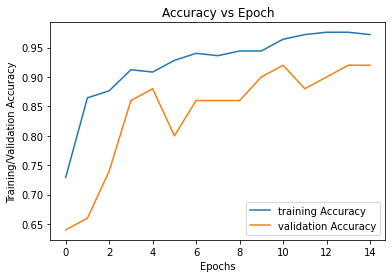

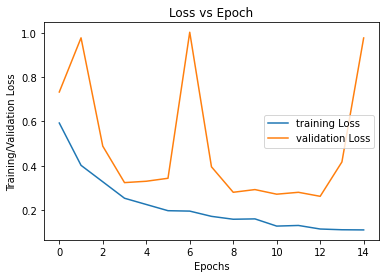

In [ ]:
train(model,loss_fn , optimizer)

In [ ]:
def predict_img(img,model): #[N C H W]
  x = img.unsqueeze(0)
  y = model(x)

  pred = torch.argmax(y,dim=1)

  return train_data.classes[pred]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label : Viral Pneumonia Prediction Label : Viral Pneumonia


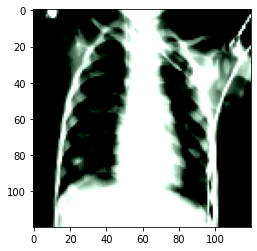

In [ ]:
img , label = test_data[2]
plt.imshow(img.permute(1,2,0))
print("Actual Label :", train_data.classes[label] , "Prediction Label :", predict_img(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label : Covid Prediction Label : Covid


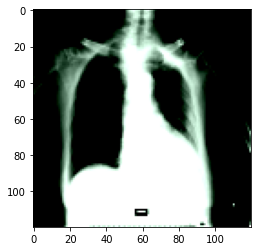

In [ ]:
img , label = test_data[10]
plt.imshow(img.permute(1,2,0))
print("Actual Label :", train_data.classes[label] , "Prediction Label :", predict_img(img,model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label : Normal Prediction Label : Normal


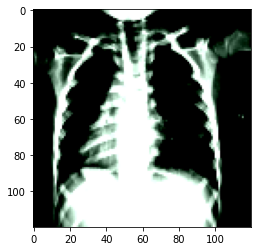

In [ ]:
img , label = test_data[15]
plt.imshow(img.permute(1,2,0))
print("Actual Label :", train_data.classes[label] , "Prediction Label :", predict_img(img,model))